In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import numpy as np
from scipy.stats import norm, zscore, pearsonr
from scipy.signal import gaussian, convolve
from sklearn import decomposition
import scipy.io
np.set_printoptions(threshold=np.nan)

import os
import copy
%load_ext autotime

In [2]:
#import audio envelope (down sample to 50Hz)
path = os.path.join('/Users/sherrychien/Desktop/mont/sherry/parachute/stimuli/parachute_intact_audenv.mat')
a1 = scipy.io.loadmat(path)
env_intact=np.reshape(a1['audenv'],((28875)))
audioenv_intact= env_intact[1275:] #remove the music part
path = os.path.join('/Users/sherrychien/Desktop/mont/sherry/parachute/stimuli/parachute_longscram_audenv.mat')
a1 = scipy.io.loadmat(path)
env_ls=np.reshape(a1['audenv'],((28875)))
audioenv_ls= env_ls[1275:]

time: 499 ms


In [3]:
# set segment duration in ms
duration = [26582,17753,20779,19543,22929,19147,22160,23415,20391,21923,26193,19517,15408,17716,15475,\
            15406,25344,28487,29716,18088,17271,29857,24453,24342,24442]
duration = [np.ceil(x/20) for x in duration] #down to 20ms (50Hz)
duration = np.asarray(duration)
duration = duration.astype(int)

time: 6.87 ms


In [4]:
#segment intact audio envelope
i=0
intact_env=[]

for j in range(len(duration)):
    intact_env.append(audioenv_intact[i:i+duration[j]])
    i=i+duration[j]

duration[-1]=1217 #shorten the last segment to match the up-sampling data


time: 7.88 ms


In [5]:
#order for transferring intact duration to longscram duration (and vice versa)
order_it2ls=[4,23,8,24,18,7,0,17,22,16,2,12,15,9,20,13,5,14,11,19,6,21,1,10,3]
order_ls2it = [6,22,10,24,0,16,20,5,2,13,23,18,11,15,17,12,9,7,4,19,14,21,8,1,3]
duration_ls = [duration[j] for j in order_it2ls]
print('duration longscram is:',duration_ls) 


duration longscram is: [1147, 1218, 1020, 1217, 1486, 1171, 1330, 1425, 1223, 1268, 1039, 771, 771, 1097, 864, 886, 958, 774, 976, 905, 1108, 1493, 888, 1310, 978]
time: 10.9 ms


In [6]:
i=0
ls_env=[]
#segment longscram audio envelope
for j in range(len(duration_ls)):
    ls_env.append(audioenv_ls[i:i+duration_ls[j]])
    i=i+duration_ls[j]

ul_env = [ls_env[j] for j in order_ls2it]  #unscramble longscram audio envelope
ul_env_ravel = np.concatenate(ul_env).ravel()

time: 11.1 ms


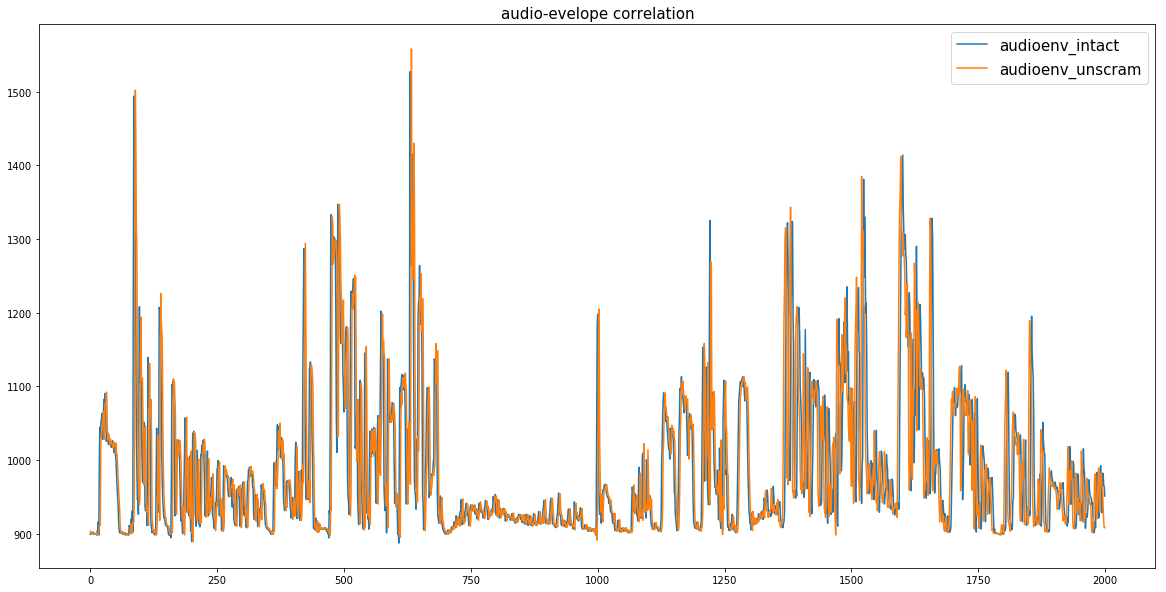

time: 828 ms


In [7]:
# Check whether the intact and unscramble audio envelope matched
plt.figure(figsize=(20,10))
plt.title("audio-evelope correlation", fontsize=15)
plt.plot(audioenv_intact[:2000], label="audioenv_intact")
plt.plot(ul_env_ravel[:2000], label="audioenv_unscram")
plt.legend(fontsize=15)

plt.show()

In [8]:
#correlation between intact and unscrambled audio envelope
np.corrcoef(audioenv_intact[:27323],ul_env_ravel)

array([[ 1.        ,  0.52332886],
       [ 0.52332886,  1.        ]])

time: 8.2 ms


# upsampling the fMRI data
import fMRI data first

In [9]:
import os
import copy
from scipy import stats
a1_BOLD_intact = []
PMC_BOLD_intact = []
name_intact = 'MSS_173031','MMX_174331','JKF_181331','JFQ_181531','JEX_181531','JQM_191331',\
'JLN_192031','SBX_213031','MBX_172331','JFX_181531','JBU_181531','JHS_183431',\
'JFG_183631','JEQ_183731','JEO_184131','NOT_231331','NWS_231831','NMA_231931',\
'NTE_232031','NUH_232131','NED_232431','JSC_193231'
for n in range(len(name_intact)):
    path = os.path.join('/Users/sherrychien/Desktop/mont/sherry/parachute/subjects',name_intact[n],'notthefall_intact/a1_3mm_trans_filtered_func_data.mat')
    path1 = os.path.join('/Users/sherrychien/Desktop/mont/sherry/parachute/subjects',name_intact[n],'notthefall_intact/post_cing_precun_3mm_trans_filtered_func_data.mat')
    a1 = scipy.io.loadmat(path)
    pmc = scipy.io.loadmat(path1)        
    BOLD = copy.deepcopy(a1['rdata'])
    BOLD1 = copy.deepcopy(pmc['rdata'])
    mean_t=np.mean(BOLD,1)
    mean_t1=np.mean(BOLD1,1)
    for t in range(400):        
        for i in range(len(mean_t)):
            BOLD[i,t] = BOLD[i,t] - mean_t[i]
        for j in range(len(mean_t1)):
            BOLD1[j,t] = BOLD1[j,t] - mean_t1[j]
            
            
    a1_BOLD_intact.append(BOLD)
    PMC_BOLD_intact.append(BOLD1)
    


a1_BOLD_intact= np.asarray(a1_BOLD_intact)
PMC_BOLD_intact= np.asarray(PMC_BOLD_intact)
a1_BOLD_intact=np.swapaxes(a1_BOLD_intact,1,2) #swap axes as [subject, pattern, time]
PMC_BOLD_intact=np.swapaxes(PMC_BOLD_intact,1,2)

time: 2min 50s


In [10]:
#import longscram data
import os
import copy
a1_BOLD_ls = []
PMC_BOLD_ls = []
name_longscram = 'JSC_193231','JNB_193231','ANT_201531','AFI_201731','AKT_202131','ATE_203131',\
'SLC_212531','OTA_222031','JTH_193431','JGT_194031','ADI_201431','AHQ_201531',\
'AEH_203631','SLT_212131','SQT_212731','SCE_212731','OKX_222031','OMT_222431',\
'OFO_223331','NTN_231731','DSN_241831','DEY_242731'
for n in range(len(name_longscram)):
    path = os.path.join('/Users/sherrychien/Desktop/mont/sherry/parachute/subjects',name_longscram[n],'notthefall_longscram/a1_3mm_trans_filtered_func_data.mat')
    path1 = os.path.join('/Users/sherrychien/Desktop/mont/sherry/parachute/subjects',name_longscram[n],'notthefall_longscram/post_cing_precun_3mm_trans_filtered_func_data.mat')
    a1 = scipy.io.loadmat(path)
    pmc = scipy.io.loadmat(path1)        
    BOLD = copy.deepcopy(a1['rdata'])
    BOLD1 = copy.deepcopy(pmc['rdata'])
    mean_t=np.mean(BOLD,1)
    mean_t1=np.mean(BOLD1,1)
    for t in range(400):        
        for i in range(len(mean_t)):
            BOLD[i,t] = BOLD[i,t] - mean_t[i]
        for j in range(len(mean_t1)):
            BOLD1[j,t] = BOLD1[j,t] - mean_t1[j]
            
            
    a1_BOLD_ls.append(BOLD)
    PMC_BOLD_ls.append(BOLD1)

a1_BOLD_ls= np.asarray(a1_BOLD_ls)
PMC_BOLD_ls= np.asarray(PMC_BOLD_ls)
a1_BOLD_ls=np.swapaxes(a1_BOLD_ls,1,2)
PMC_BOLD_ls=np.swapaxes(PMC_BOLD_ls,1,2)

time: 2min 52s


In [11]:
#crop fMRI data to match audio envelope (remove the first 5 TRs and the music part)
n_sbj,_,_=np.shape(a1_BOLD_ls)
a1_intact_crop=[]
PMC_intact_crop=[]
a1_ls_crop=[]
PMC_ls_crop=[]

for s in range(n_sbj):
    a1_intact_crop.append(a1_BOLD_intact[s,22:390,:])
    PMC_intact_crop.append(PMC_BOLD_intact[s,22:390,:])
    a1_ls_crop.append(a1_BOLD_ls[s,22:390,:])
    PMC_ls_crop.append(PMC_BOLD_ls[s,22:390,:])
    


a1_intact_crop=np.asarray(a1_intact_crop)
PMC_intact_crop=np.asarray(PMC_intact_crop)
a1_ls_crop=np.asarray(a1_ls_crop)
PMC_ls_crop=np.asarray(PMC_ls_crop)
n, t, v_a1 = np.shape(a1_intact_crop)
_,_,v_pmc = np.shape(PMC_intact_crop)


time: 220 ms


In [12]:
#upsampling the data from 368 to 27323 (20ms base)
from scipy import signal
a1_intact_resam, PMC_intact_resam, a1_ls_resam, PMC_ls_resam=([] for i in range(4))

n, t, v_a1 = np.shape(a1_intact_crop)
_,_,v_pmc = np.shape(PMC_intact_crop)

for s in range(22):
    print(s)
    a1_it_sbj=[]
    PMC_it_sbj=[]
    a1_ls_sbj=[]
    PMC_ls_sbj=[]
    print("a1 resampling")
    for v in range(v_a1):
        a1_it_sbj.append(signal.resample(a1_intact_crop[s,:,v],27323))
        a1_ls_sbj.append(signal.resample(a1_ls_crop[s,:,v],27323))
    print("PMC resampling")
    for v in range(v_pmc):
        PMC_it_sbj.append(signal.resample(PMC_intact_crop[s,:,v],27323))
        PMC_ls_sbj.append(signal.resample(PMC_ls_crop[s,:,v],27323))
        
    a1_intact_resam.append(a1_it_sbj) #after upsampling -> [sbj, voxel, timepoints] i.e. [22, 1018, 546337]
    PMC_intact_resam.append(PMC_it_sbj)
    a1_ls_resam.append(a1_ls_sbj)
    PMC_ls_resam.append(PMC_ls_sbj)



0
a1 resampling
PMC resampling
1
a1 resampling
PMC resampling
2
a1 resampling
PMC resampling
3
a1 resampling
PMC resampling
4
a1 resampling
PMC resampling
5
a1 resampling
PMC resampling
6
a1 resampling
PMC resampling
7
a1 resampling
PMC resampling
8
a1 resampling
PMC resampling
9
a1 resampling
PMC resampling
10
a1 resampling
PMC resampling
11
a1 resampling
PMC resampling
12
a1 resampling
PMC resampling
13
a1 resampling
PMC resampling
14
a1 resampling
PMC resampling
15
a1 resampling
PMC resampling
16
a1 resampling
PMC resampling
17
a1 resampling
PMC resampling
18
a1 resampling
PMC resampling
19
a1 resampling
PMC resampling
20
a1 resampling
PMC resampling
21
a1 resampling
PMC resampling
time: 10min 31s


In [ ]:
# np.save("a1_intact_resam.npy",a1_intact_resam)
# np.save("PMC_intact_resam.npy",PMC_intact_resam)
# np.save("a1_ls_resam.npy",a1_ls_resam)
# np.save("PMC_ls_resam.npy",PMC_ls_resam)

In [ ]:
# a1_intact_resam=np.load("a1_intact_resam.npy")
# PMC_intact_resam=np.load("PMC_intact_resam.npy")
# a1_ls_resam=np.load("a1_ls_resam.npy")
# PMC_ls_resam=np.load("PMC_ls_resam.npy")

In [13]:
# unscramble the upsampled longscramble data (A1)
a1_ul_all=[]
for s in range(22):
    a1_ul_seg=[]
    for v in range(1018):
        i=0
        a1_ls_seg_voxel=[]
        for j in range(len(duration_ls)):
            a1_ls_seg_voxel.append(a1_ls_resam[s][v][i:i+duration_ls[j]])   #parse the longscram data
            i=i+duration_ls[j]
        a1_ul = [a1_ls_seg_voxel[j] for j in order_ls2it] #unscramble the longscram data
        a1_ul_ravel = np.concatenate(a1_ul).ravel()
        a1_ul_seg.append(a1_ul_ravel)
        
    a1_ul_all.append(a1_ul_seg)



time: 2min 17s


In [15]:
# unscramble the upsampled longscramble data (PMC)
PMC_ul_all=[]
for s in range(22):
    PMC_ul_seg=[]
    for v in range(v_pmc):
        i=0
        PMC_ls_seg_voxel=[]
        for j in range(len(duration_ls)):
            PMC_ls_seg_voxel.append(PMC_ls_resam[s][v][i:i+duration_ls[j]])
            i=i+duration_ls[j]            
        PMC_ul = [PMC_ls_seg_voxel[j] for j in order_ls2it]
        PMC_ul_ravel = np.concatenate(PMC_ul).ravel()
        PMC_ul_seg.append(PMC_ul_ravel)
        
    PMC_ul_all.append(PMC_ul_seg)


time: 1min 12s


In [16]:
uls_pmc = np.asarray(PMC_ul_all)
uls_a1 = np.asarray(a1_ul_all)
it_pmc = np.asarray(PMC_intact_resam)
it_a1 = np.asarray(a1_intact_resam)

time: 5min 11s


# examine the temporal correlation

In [17]:
#average the pattern to get the time course
it_tc_a1=np.mean(it_a1,1)
it_tc_pmc=np.mean(it_pmc,1)
uls_tc_a1=np.mean(uls_a1,1)
uls_tc_pmc=np.mean(uls_pmc,1)

time: 2min 41s


In [18]:
#z-score the time course
for s in range(22):
    it_tc_a1[s] = stats.zscore(it_tc_a1[s])
    it_tc_pmc[s] = stats.zscore(it_tc_pmc[s]) 
    uls_tc_a1[s] = stats.zscore(uls_tc_a1[s]) 
    uls_tc_pmc[s] = stats.zscore(uls_tc_pmc[s]) 

time: 1.56 s


In [19]:
# intersubject intact-unscram temporal correlation (after remove certain TRs)
ind=np.arange(22)
r_tc_a1, r_tc_pmc = ([] for i in range(2))
delay=100 #remove certain TR
for s in range(22):
    a = ind[np.arange(len(ind))!= s]
    i=0
    r_seg_a1=[]
    r_seg_pmc=[]
    for seg in duration:
        other_a1 = np.mean(it_tc_a1[a,i+delay:i+seg],0)
        other_pmc = np.mean(it_tc_pmc[a,i+delay:i+seg],0)
        r_seg_a1.append(np.corrcoef(other_a1,uls_tc_a1[s,i+delay:i+seg])[0][1])
        r_seg_pmc.append(np.corrcoef(other_pmc,uls_tc_pmc[s,i+delay:i+seg])[0][1])
        i = i + seg
                         
    r_tc_a1.append(r_seg_a1)
    r_tc_pmc.append(r_seg_pmc)

time: 720 ms


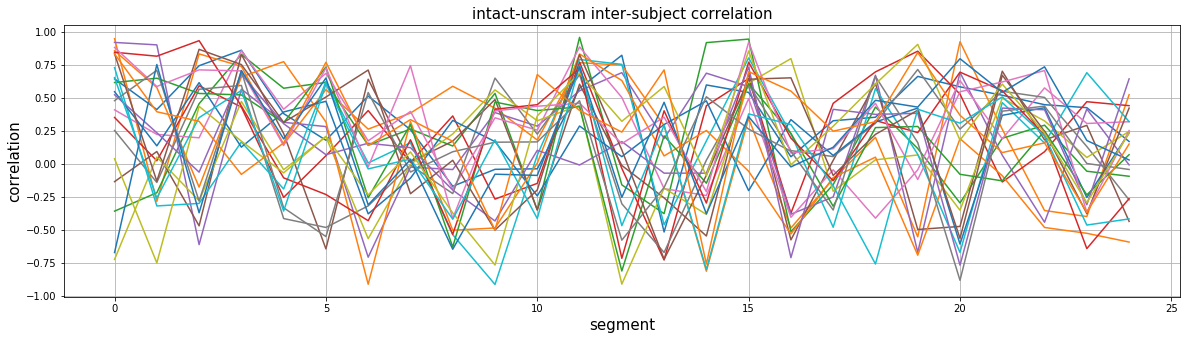

time: 7.36 s


In [20]:
#plot the correlation
plt.figure(figsize=(20,5))
plt.plot(np.transpose(r_tc_a1))
plt.xlabel('segment', fontsize = 15)
plt.ylabel('correlation', fontsize = 15)
plt.title('intact-unscram inter-subject correlation', fontsize = 15)
# plt.legend(label_sbj)
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(np.transpose(r_tc_a1))
plt.xlabel('segment', fontsize = 15)
plt.ylabel('correlation', fontsize = 15)
plt.title('unscramble-unscramble inter-subject correlation', fontsize = 15)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(np.mean(sbj_mean_it_A1,0),label="A1 data_intact")
plt.plot(np.mean(sbj_mean_ul_A1,0),label="A1 data_unscramble")
plt.title("temporal correlation in A1", fontsize=15)
plt.legend(fontsize=15)
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(np.mean(sbj_mean_it_pmc,0),label="PMC data_intact")
plt.plot(np.mean(sbj_mean_ul_pmc,0),label="PMC data_unscramble")
plt.title("temporal correlation in PMC", fontsize=15)
plt.legend(fontsize=15)
plt.show()

# Calculate pattern correlation

In [21]:
#unscram-unscram intersubject pattern correlation in A1
ind=np.arange(22)
corr_a1=[]
smooth_window=10

for s in range(22):
    print(s)
    a = ind[np.arange(len(ind))!= s] #exclude the target subject
    corr=[]
    a1_other = np.mean(uls_a1[a,:,:],0)
    print("calculate corr")
    for t in range(0,27323,smooth_window):
        others_mean=np.mean(a1_other[:,t:t+smooth_window],1)
        sbj_mean=np.mean(uls_a1[s,:,t:t+smooth_window],1)
        corr.append(np.corrcoef(sbj_mean,others_mean)[0][1])

    corr_a1.append(corr)



0
calculate corr
1
calculate corr
2
calculate corr
3
calculate corr
4
calculate corr
5
calculate corr
6
calculate corr
7
calculate corr
8
calculate corr
9
calculate corr
10
calculate corr
11
calculate corr
12
calculate corr
13
calculate corr
14
calculate corr
15
calculate corr
16
calculate corr
17
calculate corr
18
calculate corr
19
calculate corr
20
calculate corr
21
calculate corr
time: 33min 59s


In [22]:
#unscram-unscram pattern correlation in PMC

ind=np.arange(22)
corr_pmc=[]
smooth_window=10
# uls_a1 = np.mean(a1_ul_all,0)
# it_a1 = np.mean(a1_intact_resam,0)

for s in range(22):
    print(s)
    a = ind[np.arange(len(ind))!= s] #exclude the target subject
    corr=[]
    pmc_other = np.mean(uls_pmc[a,:,:],0)
    print("calculate corr")
    for t in range(0,27323,smooth_window):
        others_mean=np.mean(pmc_other[:,t:t+smooth_window],1)
        sbj_mean=np.mean(uls_pmc[s,:,t:t+smooth_window],1)
        corr.append(np.corrcoef(sbj_mean,others_mean)[0][1])

    corr_pmc.append(corr)



0
calculate corr
1
calculate corr
2
calculate corr
3
calculate corr
4
calculate corr
5
calculate corr
6
calculate corr
7
calculate corr
8
calculate corr
9
calculate corr
10
calculate corr
11
calculate corr
12
calculate corr
13
calculate corr
14
calculate corr
15
calculate corr
16
calculate corr
17
calculate corr
18
calculate corr
19
calculate corr
20
calculate corr
21
calculate corr
time: 2min 27s


In [ ]:
np.save("uls_corr_mean_a1_smoothed.npy", corr_a1)
np.save("uls_corr_mean_pmc_smoothed.npy", corr_pmc)


In [ ]:
#unscram-unscram pattern correlation in PMC (without smoothing)

ind=np.arange(22)
corr_a1=[]

for s in range(22):
    print(s)
    a = ind[np.arange(len(ind))!= s] #exclude the target subject
    corr=[]
    a1_other = np.mean(uls_a1[a,:,:],0)
    print("calculate corr")
    for t in range(27323):
        corr.append(np.corrcoef(uls_a1[s,:,t],a1_other[:,t])[0][1])

    corr_a1.append(corr)


In [ ]:
ind=np.arange(22)
corr_pmc=[]


for s in range(22):
    print(s)
    a = ind[np.arange(len(ind))!= s] #exclude the target subject
    corr=[]
    pmc_other = np.mean(uls_pmc[a,:,:],0)
    print("calculate corr")
    for t in range(27323):
        corr.append(np.corrcoef(uls_pmc[s,:,t],pmc_other[:,t])[0][1])

    corr_pmc.append(corr)



In [ ]:
corr_mean_a1=np.mean(corr_a1,0)
corr_mean_pmc=np.mean(corr_pmc,0)
np.save("uls_corr_mean_a1.npy", corr_mean_a1)
np.save("uls_corr_mean_pmc.npy", corr_mean_pmc)


In [ ]:
corr_mean_a1=np.load("ls_corr_mean_a1.npy")
corr_mean_pmc=np.load("ls_corr_mean_pmc.npy")

In [ ]:
#unscram-intact between-group average pattern correlation in A1

ind=np.arange(22)
corr_a1=[]
smooth_window=10

uls_a1 = np.mean(uls_a1,0)
it_a1 = np.mean(it_a1,0)
for t in range(0,27323,smooth_window):
    uls_a1_smooth=np.mean(uls_a1[:,t:t+smooth_window],1)
    it_a1_smooth=np.mean(it_a1[:,t:t+smooth_window],1)
#         a = ind[np.arange(len(ind))!= s] #exclude the target subject
#     a1 = uls_a1[:,t]
#     corr_mean_a1.append(np.corrcoef(it_a1[:,t],a1)[0][1])
    corr_a1.append(np.corrcoef(uls_a1_smooth,it_a1_smooth)[0][1])


In [ ]:
#unscram-intact between-group average pattern correlation in PMC

ind=np.arange(22)
corr_pmc=[]
smooth_window=10

uls_pmc_mean = np.mean(uls_pmc,0)
it_pmc_mean = np.mean(it_pmc,0)
for t in range(0,27323,smooth_window):
    uls_pmc_smooth=np.mean(uls_pmc_mean[:,t:t+smooth_window],1)
    it_pmc_smooth=np.mean(it_pmc_mean[:,t:t+smooth_window],1)
#         a = ind[np.arange(len(ind))!= s] #exclude the target subject
#     a1 = uls_a1[:,t]
#     corr_mean_a1.append(np.corrcoef(it_a1[:,t],a1)[0][1])
    corr_pmc.append(np.corrcoef(uls_pmc_smooth,it_pmc_smooth)[0][1])


In [ ]:
#unscram-intact between-group average pattern correlation in PMC (no smoothing)
ind=np.arange(22)
corr_mean_pmc=[]
uls_pmc = np.mean(uls_pmc,0)
it_pmc = np.mean(it_pmc,0)
for t in range(27323):
#         a = ind[np.arange(len(ind))!= s] #exclude the target subject
    pmc = uls_pmc[:,t]
    corr_mean_pmc.append(np.corrcoef(it_pmc[:,t],pmc)[0][1])


In [ ]:
np.save("uls_corr_all_mean_a1_smoothed.npy", corr_a1)
np.save("uls_corr_all_mean_pmc_smoothed.npy", corr_pmc)


In [ ]:
corr_a1 = np.load("it_uls_corr_mean_a1_smoothed.npy")
corr_pmc = np.load("it_uls_corr_mean_pmc_smoothed.npy")


In [23]:
#duration after smoothing
duration2=[int(x/10) for x in duration]
duration2

[133,
 88,
 103,
 97,
 114,
 95,
 110,
 117,
 102,
 109,
 131,
 97,
 77,
 88,
 77,
 77,
 126,
 142,
 148,
 90,
 86,
 149,
 122,
 121,
 121]

time: 78 ms


In [24]:
#correlation of the end of the events across subjects

from scipy import stats

lag = 60
corr_a1_mean, corr_pmc_mean=([] for i in range(2))
corr_a1_sbj, corr_pmc_sbj=([] for i in range(2))
a1_event, pmc_event=([] for i in range(2))
for s in range(22):
    d=duration2[0]
    print(s)
    for i in duration2[1:-1]:
        a1_event.append(corr_a1[s][d-lag:d])
        pmc_event.append(corr_pmc[s][d-lag:d])
        d=d+i

        a1_event_mean=np.mean(a1_event,0)
        pmc_event_mean=np.mean(pmc_event,0) 
    
    corr_a1_sbj.append(a1_event_mean)
    corr_pmc_sbj.append(pmc_event_mean)

corr_a1_mean = np.mean(corr_a1_sbj,0)
corr_pmc_mean = np.mean(corr_pmc_sbj,0)
corr_a1_std = np.std(corr_a1_sbj,0)
corr_pmc_std = np.std(corr_pmc_sbj,0)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
time: 1.86 s


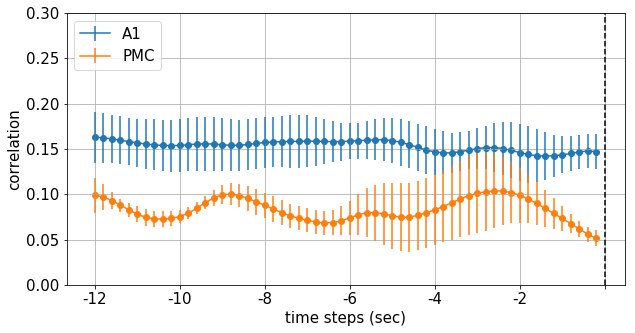

time: 691 ms


In [25]:
#plot the correlation
plt.figure(figsize=(10,5))
plt.errorbar(np.arange(lag),corr_a1_mean, yerr=corr_a1_std, label='A1')
plt.scatter(np.arange(lag),corr_a1_mean)
# plt.plot(a1_event_mean, label='A1')
plt.errorbar(np.arange(lag),corr_pmc_mean, yerr=corr_pmc_std, label='PMC')
plt.scatter(np.arange(lag),corr_pmc_mean)
# plt.plot(pmc_event_mean,label='PMC')
plt.ylim(0,0.3)
# plt.ylim(0.7,0.9)
# plt.title("average unscram data - average intact data")
plt.xticks(np.arange(0,lag+1,10),np.arange(-12,0,2), fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("correlation", fontsize=15)
plt.xlabel("time steps (sec)", fontsize=15)
plt.axvline(x=lag, linestyle='--', color = 'k')
plt.legend(fontsize=15)
plt.grid()


plt.show()

In [26]:
#correlation of the beginning of the events across subjects

lag = 60
corr_a1_mean, corr_pmc_mean=([] for i in range(2))
corr_a1_sbj, corr_pmc_sbj=([] for i in range(2))
a1_event, pmc_event=([] for i in range(2))
for s in range(22):
    d=duration2[0]
    print(s)
    for i in duration2[1:-1]:
        a1_event.append(corr_a1[s][d:d+lag])
        pmc_event.append(corr_pmc[s][d:d+lag])
        d=d+i

        a1_event_mean=np.mean(a1_event,0)
        pmc_event_mean=np.mean(pmc_event,0) 
    
    corr_a1_sbj.append(a1_event_mean)
    corr_pmc_sbj.append(pmc_event_mean)

corr_a1_mean = np.mean(corr_a1_sbj,0)
corr_pmc_mean = np.mean(corr_pmc_sbj,0)
corr_a1_std = np.std(corr_a1_sbj,0)
corr_pmc_std = np.std(corr_pmc_sbj,0)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
time: 1.74 s


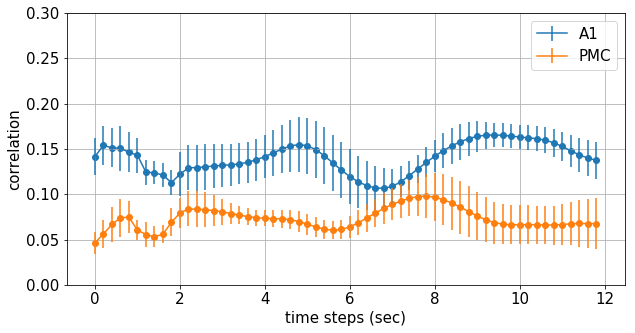

time: 427 ms


In [27]:
#plot the correlation
plt.figure(figsize=(10,5))
plt.errorbar(np.arange(lag),corr_a1_mean, yerr=corr_a1_std, label='A1')
plt.scatter(np.arange(lag),corr_a1_mean)
# plt.plot(a1_event_mean, label='A1')
plt.errorbar(np.arange(lag),corr_pmc_mean, yerr=corr_pmc_std, label='PMC')
plt.scatter(np.arange(lag),corr_pmc_mean)
# plt.plot(pmc_event_mean,label='PMC')
plt.ylim(0,0.3)
# plt.ylim(0.7,0.9)
# plt.title("average unscram data - average intact data")
plt.xticks(np.arange(0,lag+1,10),np.arange(0,14,2), fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("correlation", fontsize=15)
plt.xlabel("time steps (sec)", fontsize=15)
# plt.axvline(x=lag, linestyle='--', color = 'k')
plt.legend(fontsize=15)
plt.grid()


plt.show()